In [54]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [56]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df

pd.set_option('display.max_colwidth', 255)
df = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"


In [57]:
df = df[df['medical_specialty'].isin(['Neurosurgery','ENT - Otolaryngology','Discharge Summary'])]
shape(df,'df')

STATUS: Dimension of "df" = (300, 5)


Word Counts of Each Medical Specialty

In [58]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Neurosurgery,54233
1,Discharge Summary,43103
2,ENT - Otolaryngology,42032


In [59]:
total_word_count = df['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 139368


Sample Size of Each Medical Specialty

In [60]:
vc(df, 'medical_specialty')

STATUS: Value counts of "medical_specialty"...


,count,percentage (%)
medical_specialty,,
Discharge Summary,108,36.000000
ENT - Otolaryngology,98,32.666667
Neurosurgery,94,31.333333


 General Cleaning

In [61]:
# to print data shape
print(f'data shape is: {df.shape}')

# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

data shape is: (300, 5)


keywords             56
transcription         2
description           0
medical_specialty     0
sample_name           0
dtype: int64

In [62]:
# to remove transcription rows that is empty
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 2656 to 3994
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        298 non-null    object
 1   medical_specialty  298 non-null    object
 2   sample_name        298 non-null    object
 3   transcription      298 non-null    object
 4   keywords           242 non-null    object
dtypes: object(5)
memory usage: 14.0+ KB


In [63]:
# drop redundant columns
df =df.drop(['description','keywords'], axis=1)
df.head(2)

,medical_specialty,sample_name,transcription
2656,Neurosurgery,Wound Closure & Debridement - Hydrocephalus,"TITLE OF OPERATION:, A complex closure and debridement of wound.,INDICATION FOR SURGERY:, The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2657,Neurosurgery,VP Shunt Placement,"TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."


Lower Case

In [64]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head(3)

,medical_specialty,sample_name,transcription
2656,Neurosurgery,Wound Closure & Debridement - Hydrocephalus,"title of operation:, a complex closure and debridement of wound.,indication for surgery:, the patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2657,Neurosurgery,VP Shunt Placement,"title of operation: , placement of right new ventriculoperitoneal (vp) shunts strata valve and to removal of right frontal ommaya reservoir.,indication for surgery: , the patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."
2658,Neurosurgery,Ventriculostomy,"preoperative diagnosis: , aqueductal stenosis.,postoperative diagnosis:, aqueductal stenosis.,title of procedure: ,endoscopic third ventriculostomy.,anesthesia: , general endotracheal tube anesthesia.,devices:, bactiseal ventricular catheter with a..."


#yt

In [65]:
dff = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')

In [66]:
dff.head()


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard...","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...,"cardiovascular / pulmonary, 2-d, doppler, echocardiogram, annular, aortic root, aortic valve, atrial, atrium, calcification, cavity, ejection fraction, mitral, obliteration, outflow, regurgitation, relaxation pattern, stenosis, systolic function, tric..."


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
!pip install spacy

In [7]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.3 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578643 sha256=0e5f679a6b05a04a8d1af5235d1f17f732725fdd0f5238cc0beac311dd52ebed
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  C

In [9]:
import spacy
import scispacy

In [10]:
sci_nlp=spacy.load('en_ner_bc5cdr_md')

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [11]:
sci_nlp.component_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']

In [12]:
sci_nlp.get_pipe('ner').labels

('CHEMICAL', 'DISEASE')

In [13]:
# x="The patient presents with a persistent dry cough, often exacerbated by bouts of coughing fits, along with noticeable nasal congestion and frequent sneezing spells. Additionally, the patient reports experiencing intermittent fever episodes, with temperatures spiking particularly in the evenings, accompanied by generalized fatigue and bodyaches. The cough is further characterized by occasional chest tightness and discomfort, particularly upon deep inhalation or prolonged speaking. Furthermore, the patient describes a sore throat, exacerbated by swallowing and aggravated by postnasal drip."

In [14]:
# x

In [60]:
x="The patient complains of persistent abdominal pain, particularly in the upper abdomen. This discomfort often worsens on an empty stomach or at night and may be temporarily relieved by antacids. Along with the pain, the patient experiences frequent bloating. Additionally, there is occasional constipation and nausea. These symptoms have been ongoing for several months and tend to worsen after consuming spicy or fatty foods. "

In [61]:
docx=sci_nlp(x)

In [62]:
for ent in docx.ents:
    print(ent.text,ent.label_)

abdominal pain DISEASE
antacids CHEMICAL
pain DISEASE
bloating DISEASE
constipation DISEASE
nausea DISEASE
fatty  DISEASE


In [63]:
from spacy import displacy

In [64]:
displacy.render(docx,style='ent',jupyter=True)

#Testing

In [152]:
# Process the text in the 'description' column and create a new column for identified entities
dff['identified_entities'] = dff['transcription'].apply(lambda x: [ent.text for ent in sci_nlp(str(x)).ents if ent.label_ == 'DISEASE'])

In [153]:
dff

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,identified_entities
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,","[complaint of allergies, allergies, asthma, throat, Allergic rhinitis.,PLAN:,1]"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost","[snoring, pains, knee pain, pain, ankle pain, swelling, gastroesophageal reflux disease.,PAST, Heart disease, stroke, diabetes, Denies obesity, hypertension, allergic, chest pain, coronary artery disease, congestive heart failure, arrhythmia, atrial f..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,","[overweight, weight loss, weight loss, weight loss, asthma, apnea, snoring, diabetic, pain, knee pain, back pain, ankle pain, swelling, hemorrhoids.,PAST, Obesity, heart disease, diabetes, hypertension, heart attacks, gout, chest pain, coronary artery..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard...","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal...","[atrial enlargement, pulmonary regurgitation]"
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...,"cardiovascular / pulmonary, 2-d, doppler, echocardiogram, annular, aortic root, aortic valve, atrial, atrium, calcification, cavity, ejection fraction, mitral, obliteration, outflow, regurgitation, relaxation pattern, stenosis, systolic function, tric...","[hyperdynamic left ventricular systolic function, abnormal left ventricular relaxation, aortic valve stenosis, mitral annular calcification, mitral regurgitation.,7, tricuspid regurgitation, pulmonary artery hypertension, pericardial effusion, patent ..."
...,...,...,...,...,...,...,...
4984,4984,Patient suffered from morbid obesity for many years and made multiple attempts at nonsurgical weight loss without success.,Bar

In [155]:
import spacy
import pandas as pd

# Load the pre-trained model
sci_nlp = spacy.load('en_ner_bc5cdr_md')

# Assuming 'dff' is your dataset with 'keywords' and 'identified_entities' columns
# Drop rows where 'keywords' column is null
dff = dff.dropna(subset=['keywords'])

# Initialize a list to store the matched counts
matched_counts = []

# Initialize a set to store unique keywords
unique_keywords = set()

# Iterate over each row in the DataFrame
for index, row in dff.iterrows():
    # Split keywords into a list
    keywords = row['keywords'].split(', ')
    identified_entities = row['identified_entities']  # Already a list
    keywords=set(keywords)
    # Count the number of keywords that are present in identified_entities
    matched_count = sum(1 for keyword in keywords if keyword in identified_entities)
    # Add the matched count to the list
    matched_counts.append(matched_count)
    # Add unique keywords to the set
    unique_keywords.update(keywords)

# Output the matched counts
print(sum(matched_counts))

# Output the unique keywords
print("Unique keywords:", len(unique_keywords))


4223
Unique keywords: 10729


In [158]:
# Calculate true positive, false positive, and false negative counts
TP = sum(matched_counts)  # True positives
FP = sum(1 for count in matched_counts if count == 0)  # False positives
FN = len(dff) - TP  # False negatives

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the evaluation metrics
print("Precision:", precision)
# print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.7256013745704467
F1 Score: 0.8691088701378884


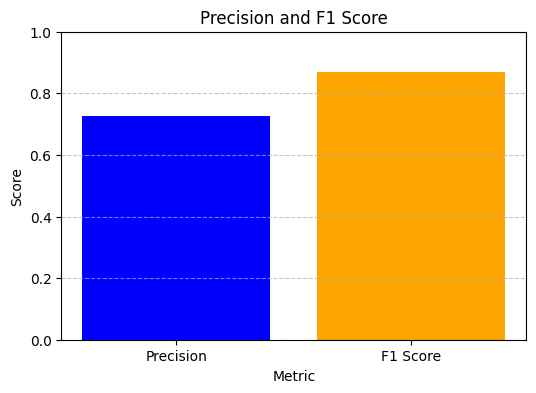

In [159]:
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ['Precision', 'F1 Score']
scores = [precision, f1_score]

# Plotting the bar graph
plt.figure(figsize=(6, 4))
plt.bar(metrics, scores, color=['blue', 'orange'])
plt.title('Precision and F1 Score')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [132]:
import pandas as pd
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the pre-trained model
# sci_nlp = spacy.load('en_core_web_sm')

# Assuming 'dff' is your dataset with 'transcription' and 'keywords' columns
# Drop rows where 'keywords' column is null
dff = dff.dropna(subset=['keywords'])

# Drop rows with missing values in the 'transcription' column
dff = dff.dropna(subset=['transcription'])

transcriptions = dff['transcription'].tolist()
keywords = dff['keywords'].tolist()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over each transcription and its corresponding keywords
for transcription, keyword in zip(transcriptions, keywords):
    # Check if transcription is not NaN
    if isinstance(transcription, str):
        doc = sci_nlp(transcription)
        true_labels.append(keyword.split(', '))
        predicted_labels.append([ent.text for ent in doc.ents if ent.label_ == 'DISEASE'])

# Flatten true and predicted labels lists
true_labels_flat = [label for sublist in true_labels for label in sublist]
predicted_labels_flat = [label for sublist in predicted_labels for label in sublist]




In [149]:
print(true_labels_flat)

['allergy / immunology', 'allergic rhinitis', 'allergies', 'asthma', 'nasal sprays', 'rhinitis', 'nasal', 'erythematous', 'allegra', 'sprays', 'allergic,', 'bariatrics', 'laparoscopic gastric bypass', 'weight loss programs', 'gastric bypass', "atkin's diet", "weight watcher's", 'body weight', 'laparoscopic gastric', 'weight loss', 'pounds', 'months', 'weight', 'laparoscopic', 'band', 'loss', 'diets', 'overweight', 'lost', 'bariatrics', 'laparoscopic gastric bypass', 'heart attacks', 'body weight', 'pulmonary embolism', 'potential complications', 'sleep study', 'weight loss', 'gastric bypass', 'anastomosis', 'loss', 'sleep', 'laparoscopic', 'gastric', 'bypass', 'heart', 'pounds', 'weight,', 'cardiovascular / pulmonary', '2-d m-mode', 'doppler', 'aortic valve', 'atrial enlargement', 'diastolic function', 'ejection fraction', 'mitral', 'mitral valve', 'pericardial effusion', 'pulmonary valve', 'regurgitation', 'systolic function', 'tricuspid', 'tricuspid valve', 'normal lv ', 'cardiovascu

In [150]:
print(predicted_labels_flat)

['complaint of allergies', 'allergies', 'asthma', 'throat', 'Allergic rhinitis.,PLAN:,1', 'snoring', 'pains', 'knee pain', 'pain', 'ankle pain', 'swelling', 'gastroesophageal reflux disease.,PAST', 'Heart disease', 'stroke', 'diabetes', 'Denies obesity', 'hypertension', 'allergic', 'chest pain', 'coronary artery disease', 'congestive heart failure', 'arrhythmia', 'atrial fibrillation', 'pulmonary embolism', 'venous insufficiency', 'thrombophlebitis', 'asthma', 'shortness of breath', 'COPD', 'emphysema', 'apnea', 'diabetes', 'osteoarthritis', 'rheumatoid arthritis', 'hernia', 'peptic ulcer disease', 'gallstones', 'pancreatitis', 'fatty liver', 'hepatitis', 'hemorrhoids', 'bleeding', 'incontinence', 'urinary stress incontinence', 'cancer', 'Denies cellulitis', 'pseudotumor', 'meningitis', 'Afebrile', 'overweight', 'weight loss', 'weight loss', 'weight loss', 'asthma', 'apnea', 'snoring', 'diabetic', 'pain', 'knee pain', 'back pain', 'ankle pain', 'swelling', 'hemorrhoids.,PAST', 'Obesity

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Check if the lengths of true and predicted labels are the same
if len(true_labels_flat) != len(predicted_labels_flat):
    # Adjust the lengths to match the shorter list
    min_length = min(len(true_labels_flat), len(predicted_labels_flat))
    true_labels_flat = true_labels_flat[:min_length]
    predicted_labels_flat = predicted_labels_flat[:min_length]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
precision = precision_score(true_labels_flat, predicted_labels_flat, average='macro')
recall = recall_score(true_labels_flat, predicted_labels_flat, average='macro')
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 8.04267982091633e-05
Precision: 5.723130231998764e-07
Recall: 6.474904570271568e-06
F1 Score: 1.0353101263893626e-06


#hugging face

In [27]:
!git lfs install

Git LFS initialized.


In [28]:
!git clone https://huggingface.co/ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1

Cloning into 'Symptoms_to_Diagnosis_SonatafyAI_BERT_v1'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 10), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (49/49), 327.07 KiB | 2.89 MiB/s, done.


In [29]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1")
model = AutoModelForSequenceClassification.from_pretrained("ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [30]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

#w2v


In [31]:
!pip install gensim

In [32]:
from gensim.models import KeyedVectors

# Load embeddings from binary files
# bio_embedding_intrinsic = KeyedVectors.load_word2vec_format('bio_embedding_intrinsic', binary=True)
bio_embedding_extrinsic = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/bio_embedding_extrinsic', binary=True)



KeyboardInterrupt: 

In [ ]:
from gensim.models import KeyedVectors

# Load embeddings from binary files
bio_embedding_intrinsic = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/bio_embedding_intrinsic', binary=True)
# bio_embedding_extrinsic = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/bio_embedding_extrinsic', binary=True)

In [ ]:
# Calculate similarity between two biomedical terms
similarity = bio_embedding_intrinsic.similarity('arrhythmia', 'leg')
print("Semantic Similarity:", similarity)


In [ ]:
import numpy as np

def document_vector(doc):
    # """Create a document vector by averaging the word vectors of all words in the document."""
    words = doc.split()
    word_vectors = [bio_embedding_extrinsic[word] for word in words if word in bio_embedding_extrinsic]
    if len(word_vectors) == 0:
        return np.zeros(200)  # Return a zero vector if no words are found
    return np.mean(word_vectors, axis=0)

# Example document
doc ="legpain"
doc_vector = document_vector(doc)
print(doc_vector.shape)
# Use doc_vector as input to a machine learning model for classification, etc.


In [ ]:
!pip install genism

In [ ]:

from gensim.models import FastText, Word2Vec, KeyedVectors # KeyedVectors are used to load the GloVe models
model = Word2Vec.load('/content/drive/MyDrive/w2v_OA_CR_100d.bin')

# Return 100-dimensional vector representations of each word
model.wv.word_vec('diabetes')
model.wv.word_vec('cardiac_arrest')
model.wv.word_vec('lymphangioleiomyomatosis')

# Try out cosine similarity
model.wv.similarity('copd', 'chronic_obstructive_pulmonary_disease')
model.wv.similarity('myocardial_infarction', 'heart_attack')
model.wv.similarity('lymphangioleiomyomatosis', 'lam')
